In [5]:
import os

import numpy as np
import pandas as pd

# Define the directory containing the results
base_dir = 'results'

# List to store individual dataframes
dataframes = []

# Some special variables to differentiate different erroneous outcomes on
EXCEPTION = 30303030303

databases = ['FlatGraph', 'OverflowDB', 'TinkerGraph', 'Neo4j']

# JAR files in ascending order of size
projects = ['Csv',
            'Cli',
            'Jacksonxml',
            'Gson',
            'Jxpath',
            'Codec',
            'Jsoup',
            'Jacksoncore',
            'Time',
            'Lang',
            'Mockito',
            'Collections',
            'Compress',
            'Jacksondatabind',
            'Chart',
            'Math',
            'Closure']


def map_driver_name(name: str) -> str:
    if name == "overflowdb":
        return "OverflowDB"
    elif name == "tinkergraph":
        return "TinkerGraph"
    elif name == "neo4j-embedded":
        return "Neo4j"
    elif name == "flatgraph":
        return "FlatGraph"
    else:
        return "Unknown ({})".format(name)

cols = ['Database', 'Project', 'Size', 'Unit']

# Walk through the directory structure
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("DS_Store"):
            continue
        file_path = os.path.join(root, file)
        # Extract <driver>, <project>, and <mem> from the path
        parts = file_path.split(os.sep)
        driver = map_driver_name(parts[1])
        project = parts[2].title()
        if file == 'storage_size.txt':
            # Check if the file is empty
            if os.path.getsize(file_path) == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            else:
                # Read the CSV file
                with open(file_path, 'r') as f:
                    file_size = float(f.readline().strip())
                    
                data = [[driver, project, file_size, "bytes"]]
                df = pd.DataFrame(data, columns=cols)
            if not df.empty:
                # Append the dataframe to the list
                dataframes.append(df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dataframes, ignore_index=True)

for d in databases:
    for p in projects:
        df = final_df
        result = df[(df["Database"] == d) & (df["Project"] == p)]
        if result.empty:
            data = [[d, p, EXCEPTION, "bytes"]]
            final_df = pd.concat([pd.DataFrame(data, columns=cols), final_df], ignore_index=True)


# Convert to Gb
final_df['Size'] = final_df['Size'].apply(lambda x: x / (1024 * 1024) if x != EXCEPTION else x)
final_df.loc[:, 'Unit'] = 'MB'

# Display the final dataframe
print(final_df)


      Database      Project          Size Unit
0        Neo4j      Closure  3.030303e+10   MB
1        Neo4j         Math  3.030303e+10   MB
2   OverflowDB      Closure  2.172266e+02   MB
3   OverflowDB     Compress  6.104688e+01   MB
4   OverflowDB  Jacksoncore  5.810938e+01   MB
..         ...          ...           ...  ...
63       Neo4j        Jsoup  1.108205e+02   MB
64       Neo4j          Csv  1.979244e+01   MB
65       Neo4j       Jxpath  1.189985e+02   MB
66       Neo4j      Mockito  1.160008e+02   MB
67       Neo4j  Collections  1.680267e+02   MB

[68 rows x 4 columns]


### Plotting

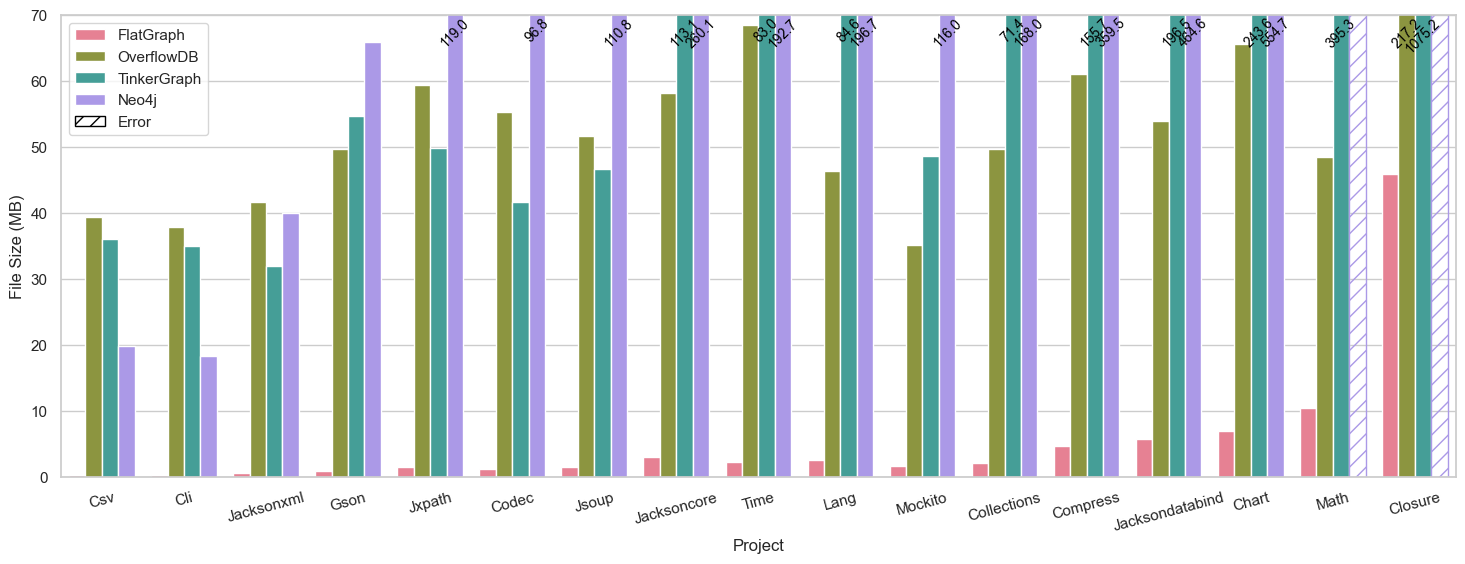

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = final_df


# Plotting with Seaborn and Matplotlib
fig, ax1 = plt.subplots(figsize=(18, 6))

# Create the bar plot for createAst
palette = sns.color_palette("husl", len(df['Database'].unique()))
sns.barplot(x="Project", y="Size", hue="Database", #yerr=df["Error"], 
            data=df, ax=ax1, palette=palette, order=projects,
            hue_order=databases)

y_limit = 70
# Set labels and title for the first y-axis
ax1.set_xlabel('Project')
ax1.set_ylabel(f'File Size ({df["Unit"].iloc[0]})')
# ax1.set_title('AST Creation Speed by Project and Database')
ax1.set_ylim(top=y_limit)

for i, patch in enumerate(ax1.patches):
    # Log errors as hatch
    h = int(patch.get_height())
    if h == EXCEPTION:
        original_color = patch.get_facecolor()
        patch.set_hatch('//')
        patch.set_facecolor('none')
        patch.set_edgecolor(original_color)
    elif patch.get_height() >= y_limit:
        # Print labels for those that exceed ylim
        yval = patch.get_height()
        ax1.text(
            patch.get_x() + patch.get_width() / 2,  # X position of the text
            min(yval, ax1.get_ylim()[1]) - 0.1,  # Y position of the text
            f'{yval:.1f}',  # Text label (value of the bar)
            ha='center',  # Horizontal alignment of the text
            va='top',  # Vertical alignment
            color='black',  # Color of the text
            fontsize=10,  # Font size
            rotation=45
        )

plt.xticks(rotation=15)

handles, labels = plt.gca().get_legend_handles_labels()

# Add the custom entry
handles.append(Patch(facecolor='white', edgecolor='black', hatch='//', label='Error'))
plt.legend(handles=handles, loc='best')

# Show the plot
plt.savefig("rq4-storage.pdf", format='pdf', bbox_inches='tight')
plt.show()
